In [1]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr
import pystac

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [26]:
longitude = 53.449941
latitude = 46.275597




geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "no2"}},
)
items = list(search.get_items())

print(f"Found {len(items)} items:")

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found 2 items:


In [27]:
import h5netcdf 
import netCDF4

items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]



data =[]
for item in file_paths:
    #signed = planetary_computer.sign_inplace(item)    
    #f = fsspec.open(signed.assets["no2"].href, expand=True).open()
    ds = xr.open_dataset(item, group="PRODUCT", engine="h5netcdf")
    data.append((generate_geographical_subset(ds, lat_min, lat_max, lon_min, lon_max)))


In [33]:
data[1]

<xarray.Dataset> Size: 2MB
Dimensions:                                               (time: 1,
                                                           scanline: 44,
                                                           ground_pixel: 49,
                                                           layer: 34,
                                                           vertices: 2,
                                                           corner: 4,
                                                           polynomial_exponents: 6,
                                                           intensity_offset_polynomial_exponents: 1)
Coordinates:
  * scanline                                              (scanline) float64 352B ...
  * ground_pixel                                          (ground_pixel) float64 392B ...
  * time                                                  (time) datetime64[ns] 8B ...
  * corner                                                (corner) float64 32B ...
  * polynomial_exponents                                  (polynomial_exponents) float64 48B ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 8B ...
  * layer                                                 (layer) float64 272B ...
  * vertices                                              (vertices) float64 16B ...
    latitude                                              (time, scanline, ground_pixel) float32 9kB ...
    longitude                                             (time, scanline, ground_pixel) float32 9kB ...
Data variables:
    delta_time                                            (time, scanline, ground_pixel) datetime64[ns] 17kB ...
    time_utc                                              (time, scanline, ground_pixel) object 17kB ...
    qa_value                                              (time, scanline, ground_pixel) float32 9kB ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 9kB ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 9kB ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 9kB ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 293kB ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 9kB ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 9kB ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 17kB ...
    tm5_constant_a                                        (layer, vertices, time, scanline, ground_pixel) float32 586kB ...
    tm5_constant_b                                        (layer, vertices, time, scanline, ground_pixel) float32 586kB ...

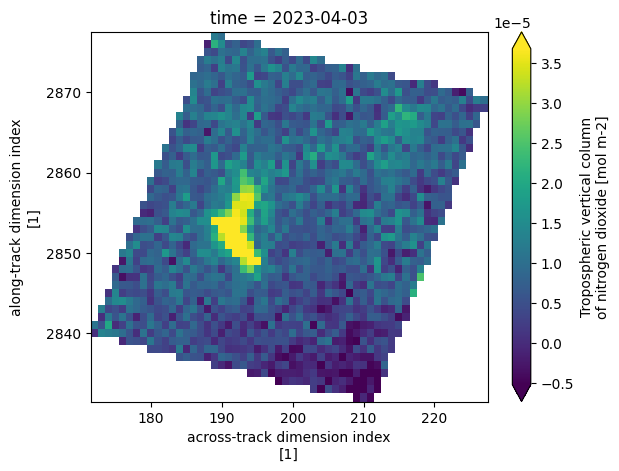

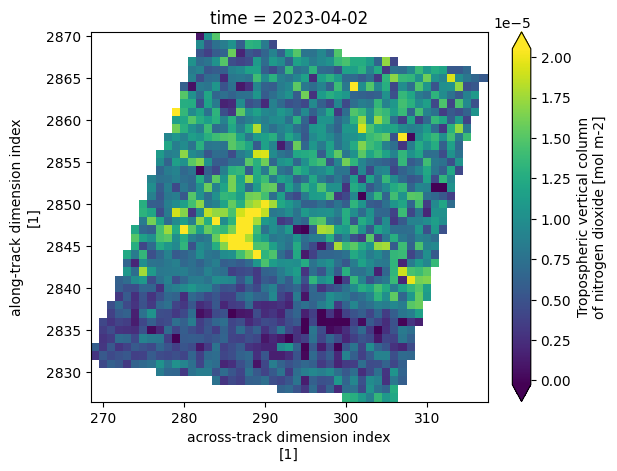

In [34]:
for i in data:
    varname = "nitrogendioxide_tropospheric_column"
    data = i[varname][0, :, :]
    vmin, vmax = np.nanpercentile(data, [1, 99])
    data.plot(vmin=vmin, vmax=vmax, cmap="viridis")
    plt.show()


In [16]:
lat_min  = 45.50
lat_max = 47.5
lon_min = 52.5
lon_max = 54.5

bbox = [ lon_min, lat_min,  lon_max, lat_max]

In [17]:
new = generate_geographical_subset(ds, lat_min, lat_max, lon_min, lon_max)

In [14]:
def generate_geographical_subset(xarray, latmin, latmax, lonmin, lonmax, reassign=False):
    """ 
    Generates a geographical subset of a xarray.DataArray and if kwarg reassign=True, shifts the longitude grid 
    from a 0-360 to a -180 to 180 deg grid.
    
    Parameters:
        xarray(xarray.DataArray): a xarray DataArray with latitude and longitude coordinates
        latmin, latmax, lonmin, lonmax(int): lat/lon boundaries of the geographical subset
        reassign(boolean): default is False
        
    Returns:
        Geographical subset of a xarray.DataArray.
    """   
    if(reassign):
        xarray = xarray.assign_coords(longitude=(((xarray.longitude + 180) % 360) - 180))
    return xarray.where(((xarray.latitude < latmax) & (xarray.latitude > latmin) & (xarray.longitude < lonmax) & (xarray.longitude > lonmin)).compute(), drop=True)

In [3]:
xr.backends.list_engines() #list backend engines. 

{'netcdf4': <NetCDF4BackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html,
 'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'rasterio': <RasterioBackend>,
 'store': <StoreBackendEntrypoint>
   Open AbstractDataStore instances in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}

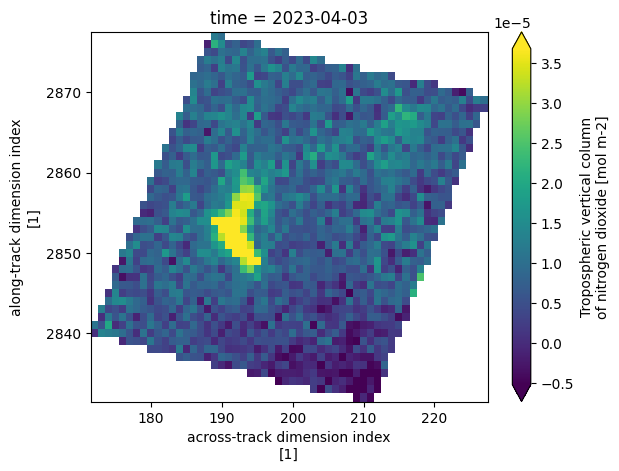

In [36]:
varname = "nitrogendioxide_tropospheric_column"
data = new[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis");

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


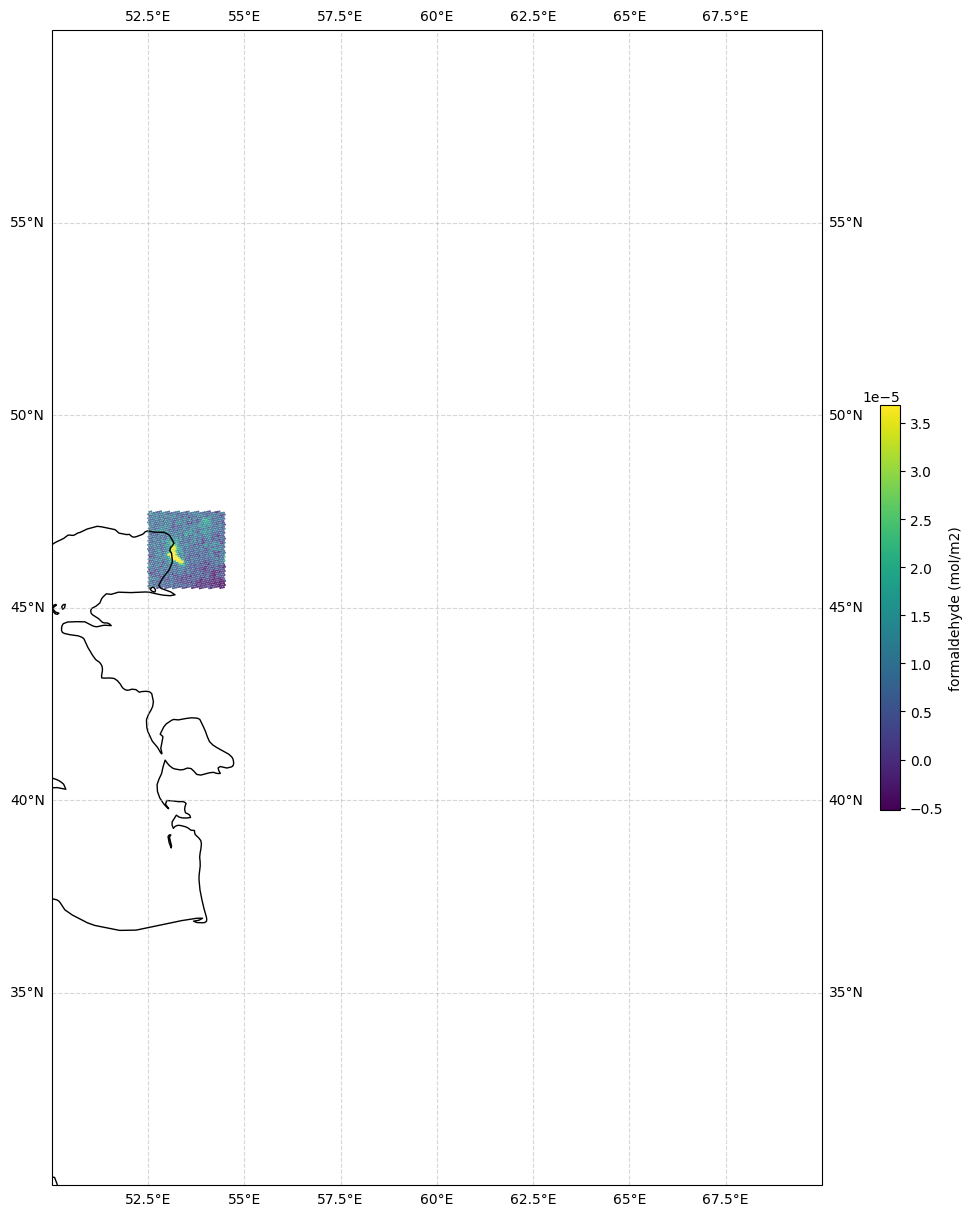

In [38]:
lon = new["longitude"].values.squeeze()
lat = new["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([50, 70, 30, 60], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()

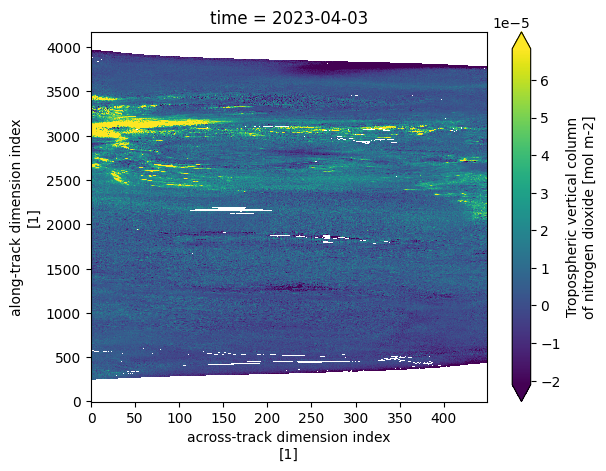

In [7]:
varname = "nitrogendioxide_tropospheric_column"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis");

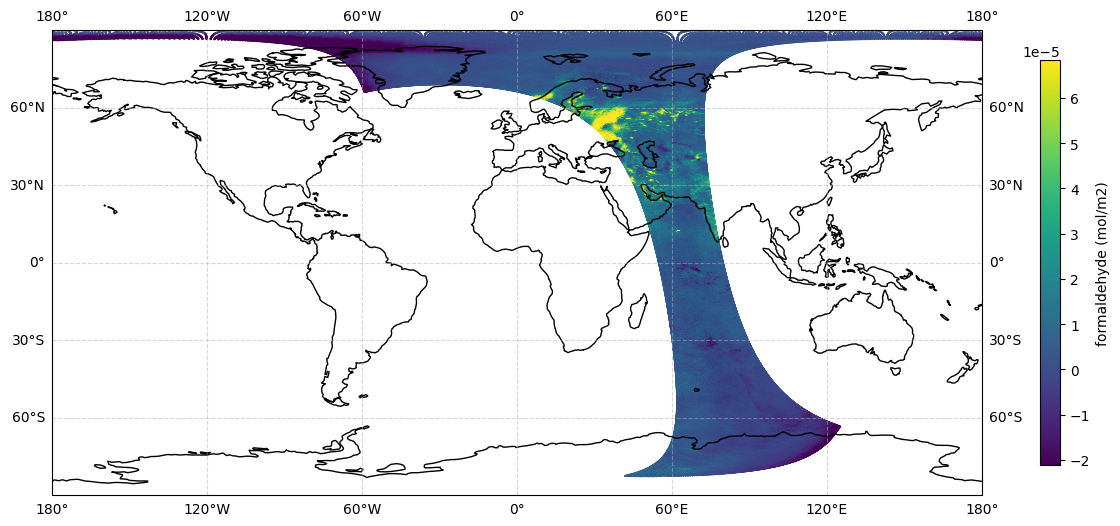

In [14]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()

In [3]:
from requests.adapters import HTTPAdapter
from urllib3 import Retry

from pystac_client import Client
from pystac_client.stac_api_io import StacApiIO

#configured to retry request multiple times. 
retry = Retry(
    total=5, backoff_factor=1, status_forcelist=[502, 503, 504], allowed_methods=None
)
stac_api_io = StacApiIO(max_retries=retry)


catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace, stac_io=stac_api_io
)

In [7]:
longitude = 53.449941
latitude = 46.275597


geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-08-02/2023-08-07",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "no2"}},
)
items = list(search.get_items())

print(f"Found {len(items)} items:")

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found 10 items:


In [8]:
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
#file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]

f = fsspec.open(signed_items[0].assets["no2"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")

KeyboardInterrupt: 

In [ ]:
data =[]


for item in items:
    f = fsspec.open(items[0].assets["no2"].href).open()
    ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")


In [6]:
items[0].assets["no2"].href

'https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__NO2___/2023/08/03/S5P_OFFL_L2__NO2____20230803T083009_20230803T101138_30077_03_020500_20230805T003657/S5P_OFFL_L2__NO2____20230803T083009_20230803T101138_30077_03_020500_20230805T003657.nc?st=2024-12-22T10%3A45%3A44Z&se=2024-12-23T11%3A30%3A44Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-22T00%3A08%3A24Z&ske=2024-12-29T00%3A08%3A24Z&sks=b&skv=2024-05-04&sig=kA71LQpZ0AYh6vv7eTOgA9FueKyAddJ2Sb1O/nfZTzg%3D'

In [26]:
items = search.get_all_items()
first_item = next(iter(items))

# Print all available assets
print("Available assets:")
for asset_name in first_item.assets.keys():
    print(asset_name)

Available assets:
no2


In [38]:
items[0]

<Item id=S5P_L2_NO2____20240803T090639_20240803T104809_35270>

In [ ]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

In [43]:
from planetary_computer import sign_inplace
signed_items = sign_inplace(items)

In [57]:
signed_items[0]

<Item id=S5P_L2_NO2____20240803T090639_20240803T104809_35270>

In [ ]:
import stackstac


ds = stackstac.stack(signed_items, assets = 'no2', bounds = bbox, resolution = 2, epsg = '4326')

In [26]:
from odc.geo.geobox import GeoBox
geobox = GeoBox.from_bbox(bbox, crs=f"epsg:{epsg}", resolution=dx)

ModuleNotFoundError: No module named 'odc'

In [25]:
ds

<xarray.DataArray 'stackstac-30e9a918cda5ed635ea21f8f50364139' (time: 0,
                                                                band: 0, y: 2,
                                                                x: 2)> Size: 0B
dask.array<fetch_raster_window, shape=(0, 0, 2, 2), dtype=float64, chunksize=(0, 0, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 0B 
    id       (time) float64 0B 
  * band     (band) float64 0B 
  * x        (x) float64 16B 52.0 54.0
  * y        (y) float64 16B 48.0 46.0
    epsg     <U4 16B '4326'
Attributes:
    spec:        RasterSpec(epsg='4326', bounds=(52, 44, 56, 48), resolutions...
    crs:         epsg:4326
    transform:   | 2.00, 0.00, 52.00|\n| 0.00,-2.00, 48.00|\n| 0.00, 0.00, 1.00|
    resolution:  2

In [ ]:
f = fsspec.open(items[0].assets["no2"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")

In [13]:
f = [fsspec.open(item.assets["no2"].href).open() for item in items]

ds = xr.merge([xr.open_dataset(file) for file in f])

FileNotFoundError: [Errno %s not found. The URL contains glob characters: you maybe needed
to pass expand=True in fsspec.open() or the storage_options of 
your library. You can also set the config value 'open_expand'
before import, or fsspec.core.DEFAULT_EXPAND at runtime, to True.] https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__NO2___/2023/08/03/S5P_OFFL_L2__NO2____20230803T083009_20230803T101138_30077_03_020500_20230805T003657/S5P_OFFL_L2__NO2____20230803T083009_20230803T101138_30077_03_020500_20230805T003657.nc?st=2024-12-22T09%3A19%3A27Z&se=2024-12-23T10%3A04%3A27Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-22T00%3A06%3A30Z&ske=2024-12-29T00%3A06%3A30Z&sks=b&skv=2024-05-04&sig=FqShj0rOlM8nFHGy22BoTQ9i00m4UofZUcyr6YxJ5cE%3D

In [71]:
# Check the type of the object returned by get_item_collections()
collections = search.get_item_collections()
print(type(collections)) 

<class 'generator'>


In [18]:
# Convert STAC items into a GeoJSON FeatureCollection
stac_json = search.item_collection_as_dict()

In [21]:
stac_json

{'type': 'FeatureCollection',
 'features': [{'id': 'S5P_L2_NO2____20230807T085506_20230807T103635_30134',
   'bbox': [-180.0, -83.911095, 180.0, 90.0],
   'type': 'Feature',
   'links': [{'rel': 'collection',
     'type': 'application/json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-5p-l2-netcdf'},
    {'rel': 'parent',
     'type': 'application/json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-5p-l2-netcdf'},
    {'rel': 'root',
     'type': 'application/json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/'},
    {'rel': 'self',
     'type': 'application/geo+json',
     'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-5p-l2-netcdf/items/S5P_L2_NO2____20230807T085506_20230807T103635_30134'},
    {'rel': 'about',
     'href': 'http://www.tropomi.eu/data-products/nitrogen-dioxide',
     'type': 'text/html'}],
   'assets': {'no2': {'href': 'https:/

In [20]:
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

KeyError: 'mgrs:utm_zone'

In [27]:
import pystac
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]

# Use xarray's open_mfdataset to open multiple files at once
# The `chunks` argument enables lazy loading with dask
ds = xr.open_mfdataset(
    file_paths,  # List of file paths (or URLs) for the 'no2' assets
    chunks={"time": 1, "lat": 100, "lon": 100},
      concat_dim='scanline',  # Lazy loading with chunking
    combine="nested", 
     engine= 'h5netcdf',
     group='PRODUCT' # Combine datasets along common coordinates (recommended for merging)
)

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [33]:
print(list(signed_items))

[<Item id=S5P_L2_NO2____20230807T085506_20230807T103635_30134>, <Item id=S5P_L2_NO2____20230807T071336_20230807T085506_30133>, <Item id=S5P_L2_NO2____20230806T091414_20230806T105543_30120>, <Item id=S5P_L2_NO2____20230806T073244_20230806T091414_30119>, <Item id=S5P_L2_NO2____20230805T093322_20230805T111452_30106>, <Item id=S5P_L2_NO2____20230805T075153_20230805T093322_30105>, <Item id=S5P_L2_NO2____20230804T081101_20230804T095230_30091>, <Item id=S5P_L2_NO2____20230803T083009_20230803T101138_30077>, <Item id=S5P_L2_NO2____20230802T084916_20230802T103046_30063>, <Item id=S5P_L2_NO2____20230802T070747_20230802T084916_30062>]


In [9]:
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)

# Open file paths using fsspec
file_paths = []
for item in signed_items:
    print(item.assets["no2"].href)
    try:
        file_paths.append(fsspec.open(item.assets["no2"].href, expand=True).open())
    except KeyError:
        print(f"Asset 'no2' not found for item: {item.id}")

NameError: name 'pystac' is not defined

In [4]:
from dask.distributed import Client

client = Client(n_workers=20, threads_per_worker=2)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 20
Total threads: 40,Total memory: 7.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36281,Workers: 20
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 7.60 GiB
Comm: tcp://127.0.0.1:34577,Total threads: 2
Dashboard: http://127.0.0.1:38207/status,Memory: 388.92 MiB
Nanny: tcp://127.0.0.1:36931,


In [37]:

# Open files with xarray
ds = xr.open_mfdataset(
    file_paths,
    chunks={"time": 1, "lat": 100, "lon": 100},
    concat_dim='scanline',
    combine="nested",
    engine='h5netcdf',
    group='PRODUCT',
    parallel= True
)


KeyboardInterrupt: 

In [ ]:
import pystac
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]

# Use xarray's open_mfdataset to open multiple files at once
# The `chunks` argument enables lazy loading with dask
ds = xr.open_mfdataset(
    file_paths,  # List of file paths (or URLs) for the 'no2' assets
    chunks={"time": 1, "lat": 100, "lon": 100},
      concat_dim='scanline',  # Lazy loading with chunking
    combine="nested", 
     engine= 'h5netcdf',
     group='PRODUCT' # Combine datasets along common coordinates (recommended for merging)
)

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import pystac
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]

# Use xarray's open_mfdataset to open multiple files at once
# The `chunks` argument enables lazy loading with dask
ds = xr.open_mfdataset(
    file_paths,  # List of file paths (or URLs) for the 'no2' assets
    chunks={"time": 1, "lat": 100, "lon": 100},
      concat_dim='scanline',  # Lazy loading with chunking
    combine="nested", 
     engine= 'h5netcdf',
     group='PRODUCT' # Combine datasets along common coordinates (recommended for merging)
)

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import pystac
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]

# Use xarray's open_mfdataset to open multiple files at once
# The `chunks` argument enables lazy loading with dask
ds = xr.open_mfdataset(
    file_paths,  # List of file paths (or URLs) for the 'no2' assets
    chunks={"time": 1, "lat": 100, "lon": 100},
      concat_dim='scanline',  # Lazy loading with chunking
    combine="nested", 
     engine= 'h5netcdf',
     group='PRODUCT' # Combine datasets along common coordinates (recommended for merging)
)

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import pystac
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
file_paths = [fsspec.open(item.assets["no2"].href).open() for item in signed_items]

# Use xarray's open_mfdataset to open multiple files at once
# The `chunks` argument enables lazy loading with dask
ds = xr.open_mfdataset(
    file_paths,  # List of file paths (or URLs) for the 'no2' assets
    chunks={"time": 1, "lat": 100, "lon": 100},
      concat_dim='scanline',  # Lazy loading with chunking
    combine="nested", 
     engine= 'h5netcdf',
     group='PRODUCT' # Combine datasets along common coordinates (recommended for merging)
)

/home/hannahnevill/Planetary_Comp_2/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:888: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [7]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

NameError: name 'dask' is not defined

In [28]:
for item in signed_items:
    print(item.assets)

{'no2': <Asset href=https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__NO2___/2023/08/07/S5P_OFFL_L2__NO2____20230807T085506_20230807T103635_30134_03_020500_20230809T012052/S5P_OFFL_L2__NO2____20230807T085506_20230807T103635_30134_03_020500_20230809T012052.nc?st=2024-12-22T13%3A16%3A20Z&se=2024-12-23T14%3A01%3A20Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-17T00%3A06%3A30Z&ske=2024-12-24T00%3A06%3A30Z&sks=b&skv=2024-05-04&sig=N2%2BVfB0lXFwRkuUMaUTRNI%2BudGfivxTzLrCethRpZ4w%3D>}
{'no2': <Asset href=https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__NO2___/2023/08/07/S5P_OFFL_L2__NO2____20230807T071336_20230807T085506_30133_03_020500_20230808T231344/S5P_OFFL_L2__NO2____20230807T071336_20230807T085506_30133_03_020500_20230808T231344.nc?st=2024-12-22T13%3A16%3A20Z&se=2024-12-23T14%3A01%3A20Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-

In [16]:
import pystac
items = list(search.get_items()) 
item_collection = pystac.ItemCollection(items)
signed_items= planetary_computer.sign_inplace(item_collection)
asset_urls = [item.assets["no2"].href for item in signed_items]  # List of URLs for specific assets

# Step 3: Use fsspec to open these files (for example, remote files from S3)
# fsspec handles the file system and enables reading from S3, HTTP, or other remote protocols.
#with fsspec.open(asset_urls[0], 'rb') as f:
    # Read the file or handle it as needed, for example, with rasterio or other libraries.

# Step 4: Use open_mfdataset to load multiple files into an xarray dataset
# If your STAC collection provides multiple files, you can open them together with open_mfdataset
ds = xr.open_mfdataset(
    asset_urls,  # List of file paths (or URLs) for the 'no2' assets
    #chunks={"time": 1, "lat": 100, "lon": 100},
    group='PRODUCT',
    concat_dim='scanline',  # Lazy loading with chunking
    combine="nested", 
    engine= 'h5netcdf' # Combine datasets along common coordinates (recommended for merging)
)

AttributeError: 'NoneType' object has no attribute 'split'

In [10]:
ds

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/53)
    Conventions:                        CF-1.7
    institution:                        KNMI
    source:                             Sentinel 5 precursor, TROPOMI, space-...
    summary:                            TROPOMI/S5P NO2 1-Orbit L2 Swath 5.5x...
    tracking_id:                        8060ac85-8365-45f1-80ca-63723da90acd
    id:                                 S5P_OFFL_L2__NO2____20230803T083009_2...
    ...                                 ...
    Status_MET_2D:                      Nominal
    Status_NISE__:                      Nominal
    Status_CTMFCT:                      Nominal
    history:                            2023-08-05 00:52:34 f_s5pops tropnll2...
    processing_status:                  OFFL-processing nominal product
    date_modified:                      2023-08-11T15:53:44Z

In [ ]:
# Check the type of the object returned by get_item_collections()
collections = search.get_item_collections()
print(type(collections)) 

<class 'generator'>
